In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from mmcv.runner import checkpoint
from mmdet.apis.inference import init_detector,LoadImage, inference_detector
import easymd

config = '/home/azure4yanan/work/Panoptic-SegFormer/configs/panformer/panformer_pvtb5_24e_coco_panoptic.py'

checkpoint = '/home/azure4yanan/work/Panoptic-SegFormer/converted_panformer_pvtb5_24e_coco_panoptic.pth'

model = init_detector(config,checkpoint=checkpoint)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load checkpoint from local path: /home/azure4yanan/work/Panoptic-SegFormer/converted_panformer_pvtb5_24e_coco_panoptic.pth


/usr/local/lib/python3.8/dist-packages/mmdet/apis/inference.py:51: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [3]:
img = 'test_images/view_2.jpg'
results = inference_detector(model,['./'+img])

/usr/local/lib/python3.8/dist-packages/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/mmdet/models/utils/positional_encoding.py:81: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature**(2 * (dim_t // 2) / self.num_feats)
/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/A

In [4]:
print(results.keys())

dict_keys(['bbox', 'segm', 'panoptic'])


In [5]:
from easymd.datasets.panopticapi.utils import get_traceback, IdGenerator, id2rgb, rgb2id, save_json  
from easymd.datasets.coco_panoptic import id_and_category_maps as coco_categories_dict

In [6]:
import PIL.Image as Image
import json
from easymd.models.utils.visual import Visualizer
import torch
from detectron2.data import MetadataCatalog
import mmcv
import os

In [7]:
OFFSET = 1000
VOID=0

In [8]:
categories_dict = coco_categories_dict
categories = {el['id']: el for el in categories_dict}

original_format, file_name,shape = results['panoptic'][0]
id_and_category_maps = OFFSET * original_format[:, :, 0] + original_format[:, :, 1]
pan_format = np.zeros((original_format.shape[0], original_format.shape[1], 3), dtype=np.uint8)

id_generator = IdGenerator(categories)
l = np.unique(id_and_category_maps)
segm_info = []

for el in l:
    sem = el // OFFSET
    if sem == VOID:
        continue
    if sem not in categories:
        raise KeyError('Unknown semantic label {}'.format(sem))
    mask = id_and_category_maps == el
    segment_id, color = id_generator.get_id_and_color(sem)
    pan_format[mask] = color
    segm_info.append({"id": segment_id, "isthing": categories[int(sem)]['isthing']==1,"category_id": int(sem)})
    
suffix = '.png'
pan_format = pan_format[:,:,::-1]
im = Image.open(img)
im = np.array(im)[:, :, ::-1] 
meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")
v = Visualizer(im, meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(torch.from_numpy(rgb2id(pan_format[:,:,::-1])), segm_info, area_threshold=0)
mmcv.imwrite(v.get_image(),os.path.join('./', img+'_pvtb5'+suffix))

True

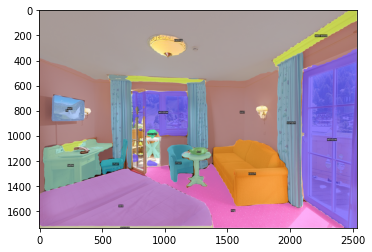

In [9]:
import matplotlib.image as mpimg
plt.figure()
vis_img = mpimg.imread(os.path.join('./', img+'_pvtb5'+suffix))
imgplot = plt.imshow(vis_img)
plt.show()

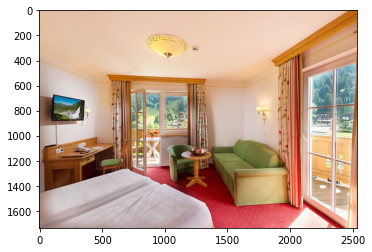

In [10]:
plt.figure(2)
vis_img2 = mpimg.imread(img)
imgplot = plt.imshow(vis_img2)
plt.show()